### Предсказание LTV30

#### Задача

Решаемая задача - построение модели для предсказания LTV30, т.е. суммарного дохода, который пользователь принесет в течение первых 30 дней после регистрации, по данным пользователя за первые 7 дней.

Данные были разделены на тренировочную и тестовую выборки следующим образом:
* train - данные пользователей, зарегистрировавшихся с 1-го по 90-й день 2017 года (первые 3 месяца)
* test - данные пользователей, зарегистрировавшихся с 91-го по 120-й день 2017 года (4-й месяц).

Из предоставленных пользовательских данных были получены признаки, по которым для каждого пользователя осуществлялось предсказание целевой переменной - суммарного дохода от него за первые 30 дней. Было построено несколько регрессионных моделей с использованием различных методов машинного обучения. Для оценки качества и сравнения моделей использовались метрики MAE и RMSE. Значения метрик были посчитаны для прогнозов LTV30 каждого пользователя отдельно и для прогнозов суммарного LTV30 всех пользователей, зарегистрировавшихся в один день.


#### Описание используемых данных

practice_dau_ios - ежедневные сообщения с устройства игрока
* id - идентификатор игрока;
* сountry - страна;
* number_of_pgr - количество PGR-сообщений (их шлет устройство во время игры);
* actdate - дата события.

practice_pact_ios - агрегированные данные о деятельности игрока в этот день
* id - идентификатор игрока;
* actdate - дата события;
* regdate - дата регистрации игрока;
* clusters_ml_ended - сколько кластеров (кластеры состоят из квестов) основной сюжетной линии прошел игрок;
* revenue - прибыль с игрока;
* transactions - количество платежей;
* quests_end - сколько побочных квестов прошел игрок;
* m_quests_end - сколько квестов основной сюжетной линии прошел игрок;
* crystals_value_spend - сколько кристаллов (в определенной нормировке) потратил игрок;
* store_enters - сколько раз игрок зашел в магазин.

practice_sessions_ios - данные о сессиях игрока
* id - идентификатор игрока;
* session_number - порядковый номер сессии игрока;
* session_length - длина сессии;
* session_start_time - время начала сессии,
* session_end_time - время окончания сессии,
* actdate - дата события.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import mode

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
dau = pd.read_csv("practice_dau_ios.csv", sep="|", names=["id", 
                                                          "country", 
                                                          "number_of_pgr", 
                                                          "actdate"])
dau.head()

,id,country,number_of_pgr,actdate
0,c1d690f4ce,AU,9,2017-02-21
1,c1d690f4ce,AU,32,2017-02-18
2,c1d690f4ce,AU,11,2017-02-12
3,c1d690f4ce,AU,2,2017-02-17
4,c1d690f4ce,AU,4,2017-02-16


In [5]:
pact = pd.read_csv("practice_pact_ios.csv", sep="|", 
                   names=["id", 
                          "actdate", 
                          "regdate", 
                          "clusters_ml_ended", 
                          "revenue", 
                          "transactions", 
                          "quests_end", 
                          "m_quests_end", 
                          "crystals_value_spend", 
                          "store_enters",
                         ])
pact.head()

,id,actdate,regdate,clusters_ml_ended,revenue,transactions,quests_end,m_quests_end,crystals_value_spend,store_enters
0,767bc9dfd3,2017-01-01,2017-01-01,1,0.0,0,9,0,0,0
1,249241537d,2017-01-01,2017-01-01,3,0.0,0,49,7,0,0
2,740d34570d,2017-01-01,2017-01-01,7,0.0,0,138,25,0,0
3,d288a3fd89,2017-01-02,2017-01-02,-2,0.0,0,0,0,0,0
4,ed716df037,2017-01-02,2017-01-01,2,0.0,0,3,1,0,0


In [6]:
sessions = pd.read_csv("practice_sessions_ios.csv", sep="|", 
                       names=["id", 
                              "session_number", 
                              "session_length", 
                              "session_start_time", 
                              "session_end_time", 
                              "actdate",
                             ])
sessions.head()

,id,session_number,session_length,session_start_time,session_end_time,actdate
0,00e954a1b3,12.0,29,1486997200,1486997229,2017-02-13
1,028498cd03,1.0,445,1485039376,1485039821,2017-01-21
2,12ab1dfa82,8.0,0,1486756815,1486756815,2017-02-10
3,0a0a1ffe3b,5.0,2846,1484976494,1484979340,2017-01-21
4,01c68437aa,7.0,1610,1484329332,1484330942,2017-01-13


In [7]:
def to_days(date):
    months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    year, month, day = list(map(int, date.split("-")))
    days = sum(months[:month - 1]) + day
    return days

In [8]:
dau["actday"] = dau["actdate"].apply(to_days)

pact["actday"] = pact["actdate"].apply(to_days)
pact["regday"] = pact["regdate"].apply(to_days)
pact["days_after_reg"] = pact.actday - pact.regday

sessions["actday"] = sessions["actdate"].apply(to_days)

In [9]:
# train

# данные пользователей, которые зарегистрировались в первые 3 месяца
# только о событиях в первые 30 дней после регистрации
n_months = 3
df = pact[np.logical_and(pact.regday <= 30 * n_months, pact.days_after_reg < 30)]

# доход с пользователя за первые 30 дней после регистрации
month_revenue = df.groupby("id")["revenue"].sum()

# целевая переменная - доход с пользователя в течение первых 30 дней
y = month_revenue

In [10]:
# test

# данные пользователей, которые зарегистрировались в 4ом месяце
# только о событиях в первые 30 дней после регистрации
n_months_test = 4
df_test = pact[np.logical_and(
    np.logical_and(pact.regday > 30 * n_months, pact.regday <= 30 * n_months_test), 
    pact.days_after_reg < 30)]

# доход с пользователя за первые 30 дней после регистрации
month_revenue_test = df_test.groupby("id")["revenue"].sum()

# целевая переменная - доход с пользователя в течение первых 30 дней
y_test = month_revenue_test

In [11]:
id_train = y.index
id_test = y_test.index

#### Создание и отбор признаков для модели

Для каждого пользователя были получены временные ряды по первым 30 дням после регистрации для таких параметров, как: 
* прибыль с пользователя за день (revenue)
* число оплат за день (transactions)
* количество пройденных квестов за день (quests, m_quests)
* суммарное количество времени, проведенного в игре, за день (sessions)
* количество заходов в игру за день (visits).

Затем по первым 7 дням временных рядов были получены агрегированные признаки для модели, такие как суммы значений за первые 7 дней и  коэффициенты линейных регрессий, аппроксимирующих значения за первые 7 дней.

In [12]:
def get_time_series(days_data, index, col_name, n_days=30, with_nan=False):
    days_data = days_data.set_index(index)
    t = pd.Series(days_data.loc[:, col_name], index=np.arange(0, n_days))
    if not with_nan:
        t.fillna(0, inplace=True)
    return t.values

In [13]:
def get_time_series_dataset(grouped_dataset, group_id, feature, period_feature, n_days, with_nan=False, feature_name=None):
    time_series = np.zeros((group_id.size, n_days))
    for i in range(group_id.size):
        if group_id[i] in grouped_dataset.groups:
            time_series[i] = get_time_series(grouped_dataset.get_group(group_id[i])[[feature, period_feature]], 
                                             index=period_feature, col_name=feature, n_days=n_days, with_nan=with_nan)
    columns = np.arange(1, n_days + 1)
    if feature_name is not None:
        columns = [feature_name + str(i) for i in columns]
    time_series = pd.DataFrame(time_series, index=group_id, columns=columns)
    return time_series

In [14]:
grouped = pd.DataFrame(df.groupby(["id", "days_after_reg"]).sum()).reset_index()
grouped = grouped.groupby("id")
grouped_test = pd.DataFrame(df_test.groupby(["id", "days_after_reg"]).sum()).reset_index()
grouped_test = grouped_test.groupby("id")

n_days = 30

revenue_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=id_train, feature="revenue", period_feature="days_after_reg", n_days=n_days, feature_name="revenue")
revenue_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=id_test, feature="revenue", period_feature="days_after_reg", n_days=n_days, feature_name="revenue")

quests_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=id_train, feature="quests_end", period_feature="days_after_reg", n_days=n_days, feature_name="quests")
quests_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=id_test, feature="quests_end", period_feature="days_after_reg", n_days=n_days, feature_name="quests")

m_quests_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=id_train, feature="m_quests_end", period_feature="days_after_reg", n_days=n_days, feature_name="m_quests")
m_quests_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=id_test, feature="m_quests_end", period_feature="days_after_reg", n_days=n_days, feature_name="m_quests")

clusters_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=id_train, feature="clusters_ml_ended", period_feature="days_after_reg", n_days=n_days, feature_name="clusters")
clusters_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=id_test, feature="clusters_ml_ended", period_feature="days_after_reg", n_days=n_days, feature_name="clusters")

In [15]:
all_quests_ts = pd.DataFrame(m_quests_ts.values + quests_ts.values, index=id_train, columns=["all_quests" + str(i) for i in np.arange(1, n_days + 1)])
all_quests_ts_test = pd.DataFrame(m_quests_ts_test.values + quests_ts_test.values, index=id_test, columns=["all_quests" + str(i) for i in np.arange(1, n_days + 1)])

In [16]:
regday = df.loc[df.id.isin(id_train), :].groupby("id")["regday"].min()
session = sessions.loc[sessions.id.isin(id_train)]
session = session.join(regday, on="id")
session["days_after_reg"] = session.actday - session.regday

# сессии игроков в течение первых 30 после регистрации
month_session = session.loc[np.logical_and(session.days_after_reg >= 0, session.days_after_reg < 30), :]
grouped = pd.DataFrame(month_session.groupby(["id", "days_after_reg"]).session_length.sum()).reset_index()
grouped = grouped.groupby("id")

In [17]:
regday_test = df_test.loc[df_test.id.isin(id_test), :].groupby("id")["regday"].min()
session_test = sessions.loc[sessions.id.isin(id_test)]
session_test = session_test.join(regday_test, on="id")
session_test["days_after_reg"] = session_test.actday - session_test.regday

# сессии игроков в течение первых 30 после регистрации
month_session_test = session_test.loc[np.logical_and(session_test.days_after_reg >= 0, session_test.days_after_reg < 30), :]
grouped_test = pd.DataFrame(month_session_test.groupby(["id", "days_after_reg"]).session_length.sum()).reset_index()
grouped_test = grouped_test.groupby("id")

In [18]:
n_days = 30

session_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=id_train, feature="session_length", period_feature="days_after_reg", n_days=n_days, feature_name="session")
session_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=id_test, feature="session_length", period_feature="days_after_reg", n_days=n_days, feature_name="session")

In [19]:
session["visit"] = np.ones(session.shape[0])
session_test["visit"] = np.ones(session_test.shape[0])

grouped = pd.DataFrame(session.groupby(["id", "days_after_reg"]).sum()).reset_index()
grouped = grouped.groupby("id")
grouped_test = pd.DataFrame(session_test.groupby(["id", "days_after_reg"]).sum()).reset_index()
grouped_test = grouped_test.groupby("id")

n_days = 30

# число посещений
visit_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=id_train, feature="visit", period_feature="days_after_reg", n_days=n_days, feature_name="visit")
visit_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=id_test, feature="visit", period_feature="days_after_reg", n_days=n_days, feature_name="visit")

# число дней, когда пользователь заходил в игру
visit_nan_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=id_train, feature="visit", period_feature="days_after_reg", n_days=n_days, with_nan=True, feature_name="visit_days")
visit_nan_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=id_test, feature="visit", period_feature="days_after_reg", n_days=n_days, with_nan=True, feature_name="visit_days")

visit_days_ts = visit_nan_ts.notnull()
visit_days_ts_test = visit_nan_ts_test.notnull()

In [20]:
# коэффициенты регрессий по временным рядам (по значениям признаков в первые 7 дней)

In [21]:
def get_lr_coefs(time_series, n_train_days, start_day=0, prefix="lr_", with_nan=False, feature_func=None):
    n_obj = time_series.shape[0]
    lr_coefs = np.zeros((n_obj, 2))
    for i in range(n_obj):
        lr = LinearRegression()
        Xi = np.arange(start_day, n_train_days).reshape(-1, 1)
        if feature_func is not None:
            Xi = feature_func(Xi)
        yi = time_series.iloc[i, start_day:n_train_days].values
        if with_nan:
            yi = yi[np.logical_not(np.isnan(yi))]
            Xi = np.arange(0, yi.size).reshape(-1, 1)
        lr.fit(Xi, yi)
        lr_coefs[i] = [lr.intercept_] + lr.coef_.tolist()
    col = list(map(lambda x: prefix + str(x), np.arange(2)))
    lr_coefs = pd.DataFrame(lr_coefs, index=time_series.index, columns=col)
    return lr_coefs

In [22]:
n_train_days = 7

sessions_lr_coefs = get_lr_coefs(session_ts, n_train_days=7, start_day=0, prefix="sessions_lr_")
sessions_lr_coefs_test = get_lr_coefs(session_ts_test, n_train_days=7, start_day=0, prefix="sessions_lr_")

revenue_lr_coefs = get_lr_coefs(revenue_ts, n_train_days=7, start_day=0, prefix="revenue_lr_")
revenue_lr_coefs_test = get_lr_coefs(revenue_ts_test, n_train_days=7, start_day=0, prefix="revenue_lr_")

all_quests_lr_coefs = get_lr_coefs(all_quests_ts, n_train_days=7, start_day=0, prefix="all_quests_lr_")
all_quests_lr_coefs_test = get_lr_coefs(all_quests_ts_test, n_train_days=7, start_day=0, prefix="all_quests_lr_")

clusters_lr_coefs = get_lr_coefs(clusters_ts, n_train_days=7, start_day=0, prefix="clusters_lr_")
clusters_lr_coefs_test = get_lr_coefs(clusters_ts_test, n_train_days=7, start_day=0, prefix="clusters_lr_")

In [23]:
# коэффициенты регрессий для отношений признаков

In [24]:
revenue_all_quests_lr_coefs = get_lr_coefs((revenue_ts / (all_quests_ts.values + 1)), n_train_days=7, start_day=0, prefix="revenue/all_quests_lr_")
revenue_all_quests_lr_coefs_test = get_lr_coefs((revenue_ts_test / (all_quests_ts_test.values + 1)), n_train_days=7, start_day=0, prefix="revenue/all_quests_lr_")

all_quests_revenue_lr_coefs = get_lr_coefs((all_quests_ts / (revenue_ts.values + 1)), n_train_days=7, start_day=0, prefix="all_quests/revenue_lr_")
all_quests_revenue_lr_coefs_test = get_lr_coefs((all_quests_ts_test / (revenue_ts_test.values + 1)), n_train_days=7, start_day=0, prefix="all_quests/revenue_lr_")

revenue_sessions_lr_coefs = get_lr_coefs((revenue_ts / (session_ts.values + 1)), n_train_days=7, start_day=0, prefix="revenue/sessions_lr_")
revenue_sessions_lr_coefs_test = get_lr_coefs((revenue_ts_test / (session_ts_test.values + 1)), n_train_days=7, start_day=0, prefix="revenue/sessions_lr_")

all_quests_sessions_lr_coefs = get_lr_coefs((all_quests_ts / (session_ts.values + 1)), n_train_days=7, start_day=0, prefix="all_quests/sessions_lr_")
all_quests_sessions_lr_coefs_test = get_lr_coefs((all_quests_ts_test / (session_ts_test.values + 1)), n_train_days=7, start_day=0, prefix="all_quests/sessions_lr_")

In [25]:
# модель

In [26]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [27]:
def train_model(X, y, X_test, y_test, model):
    model.fit(X, y)
    y_pred = model.predict(X)
    y_pred_test = model.predict(X_test)
    return model, y_pred, y_pred_test

In [28]:
X = pd.DataFrame(np.column_stack((
    # коэффициенты регрессий по временным рядам
    revenue_lr_coefs,
    all_quests_lr_coefs,
    clusters_lr_coefs,
    sessions_lr_coefs,
    
    # коэффициенты регрессий для отношений признаков
    revenue_all_quests_lr_coefs,
    revenue_sessions_lr_coefs,
    all_quests_revenue_lr_coefs,
    all_quests_sessions_lr_coefs,

    # число дней посещений за 7 дней
    visit_days_ts.iloc[:, :7].sum(axis=1),
    visit_days_ts.iloc[:, :7].sum(axis=1) ** 2,
    
    # суммарный доход / число посещений
    revenue_ts.iloc[:, :7].sum(axis=1) / (visit_days_ts.iloc[:, :7].sum(axis=1) + 1),
    visit_days_ts.iloc[:, :7].sum(axis=1) / (revenue_ts.iloc[:, :7].sum(axis=1) + 1),
    )),
                          index=id_train,
                          columns=[
                              # коэффициенты регрессий по временным рядам
                              ["revenue_lr_" + str(i) for i in range(2)] + \
                              ["all_quests_lr_" + str(i) for i in range(2)] + \
                              ["clusters_lr" + str(i) for i in range(2)] + \
                              ["session_lr" + str(i) for i in range(2)] + \
                              
                              # коэффициенты регрессий для отношений признаков
                              ["revenue_all_quests_lr_" + str(i) for i in range(2)] + \
                              ["revenue_sessions_lr_" + str(i) for i in range(2)] + \
                              ["all_quests_revenue_lr" + str(i) for i in range(2)] + \
                              ["all_quests_sessions_lr" + str(i) for i in range(2)] + \
                              
                              # 10 самых популярных стран
#                               l_enc_countries.inverse_transform(top_countries[:10].index).tolist() + \
                              
                              # число дней посещений за 7 дней
                              ["visit_days7", "visit_days7_2"] + \
                              
                              # суммарный доход / число посещений
                              ["revenue/visit_days7", "visit_days/revenue7"] + \
                              []
                          ])

X.head()

,revenue_lr_0,revenue_lr_1,all_quests_lr_0,all_quests_lr_1,clusters_lr0,clusters_lr1,session_lr0,session_lr1,revenue_all_quests_lr_0,revenue_all_quests_lr_1,revenue_sessions_lr_0,revenue_sessions_lr_1,all_quests_revenue_lr0,all_quests_revenue_lr1,all_quests_sessions_lr0,all_quests_sessions_lr1,visit_days7,visit_days7_2,revenue/visit_days7,visit_days/revenue7
id,,,,,,,,,,,,,,,,,,,,
000192edb1,0.000000,0.000000e+00,27.714286,-4.285714,4.321429,1.035714,2246.857143,-292.428571,0.000000,0.000000e+00,0.000000,0.000000e+00,27.714286,-4.285714,0.010476,-0.000192,7.0,49.0,0.00000,7.000000
0001a94437,120.355714,-2.525871e-16,36.392857,-4.464286,5.857143,1.000000,2959.107143,-199.750000,15.044464,-3.157339e-17,0.126424,-1.337399e-18,35.394043,-4.464286,0.012172,-0.001416,7.0,49.0,105.31125,0.008299
00028007b9,0.000000,0.000000e+00,1.428571,-0.285714,-0.928571,0.214286,45.714286,-9.571429,0.000000,0.000000e+00,0.000000,0.000000e+00,1.428571,-0.285714,0.015873,-0.003175,2.0,4.0,0.00000,2.000000
000303d57f,0.000000,0.000000e+00,15.178571,-2.107143,2.928571,-0.071429,1098.357143,-134.642857,0.000000,0.000000e+00,0.000000,0.000000e+00,15.178571,-2.107143,0.012146,-0.001670,4.0,16.0,0.00000,4.000000
000574057b,0.000000,0.000000e+00,5.107143,-1.178571,0.928571,-0.214286,241.892857,-55.821429,0.000000,0.000000e+00,0.000000,0.000000e+00,5.107143,-1.178571,0.009784,-0.002258,1.0,1.0,0.00000,1.000000


In [29]:
X_test = pd.DataFrame(np.column_stack((
    # коэффициенты регрессий по временным рядам
    revenue_lr_coefs_test,
    all_quests_lr_coefs_test,
    clusters_lr_coefs_test,
    sessions_lr_coefs_test,
    
    # коэффициенты регрессий для отношений признаков
    revenue_all_quests_lr_coefs_test,
    revenue_sessions_lr_coefs_test,
    all_quests_revenue_lr_coefs_test,
    all_quests_sessions_lr_coefs_test,
    
    # число дней посещений за 7 дней
    visit_days_ts_test.iloc[:, :7].sum(axis=1),
    visit_days_ts_test.iloc[:, :7].sum(axis=1) ** 2,
        
    # суммарный доход / число посещений
    revenue_ts_test.iloc[:, :7].sum(axis=1) / (visit_days_ts_test.iloc[:, :7].sum(axis=1) + 1),
    visit_days_ts_test.iloc[:, :7].sum(axis=1) / (revenue_ts_test.iloc[:, :7].sum(axis=1) + 1),
    )),
                          index=id_test,
                          columns=[
                              # коэффициенты регрессий по временным рядам
                              ["revenue_lr_" + str(i) for i in range(2)] + \
                              ["all_quests_lr_" + str(i) for i in range(2)] + \
                              ["clusters_lr" + str(i) for i in range(2)] + \
                              ["session_lr" + str(i) for i in range(2)] + \
                              
                              # коэффициенты регрессий для отношений признаков
                              ["revenue_all_quests_lr_" + str(i) for i in range(2)] + \
                              ["revenue_sessions_lr_" + str(i) for i in range(2)] + \
                              ["all_quests_revenue_lr" + str(i) for i in range(2)] + \
                              ["all_quests_sessions_lr" + str(i) for i in range(2)] + \
                              
                              # число дней посещений за 7 дней
                              ["visit_days7", "visit_days7_2"] + \
                              
                              # суммарный доход / число посещений
                              ["revenue/visit_days7", "visit_days/revenue7"] + \
                              []
                          ])

X_test.head()

,revenue_lr_0,revenue_lr_1,all_quests_lr_0,all_quests_lr_1,clusters_lr0,clusters_lr1,session_lr0,session_lr1,revenue_all_quests_lr_0,revenue_all_quests_lr_1,revenue_sessions_lr_0,revenue_sessions_lr_1,all_quests_revenue_lr0,all_quests_revenue_lr1,all_quests_sessions_lr0,all_quests_sessions_lr1,visit_days7,visit_days7_2,revenue/visit_days7,visit_days/revenue7
id,,,,,,,,,,,,,,,,,,,,
00007f9ab0,0.0,0.0,20.892857,-4.821429,2.785714,-0.642857,973.142857,-224.571429,0.0,0.0,0.0,0.0,20.892857,-4.821429,0.009963,-0.002299,1.0,1.0,0.0,1.0
00054738b4,0.0,0.0,13.000000,-3.000000,1.392857,-0.321429,727.071429,-167.785714,0.0,0.0,0.0,0.0,13.000000,-3.000000,0.008296,-0.001914,1.0,1.0,0.0,1.0
0007d2fcc5,0.0,0.0,2.785714,-0.642857,0.464286,-0.107143,112.821429,-26.035714,0.0,0.0,0.0,0.0,2.785714,-0.642857,0.011417,-0.002635,1.0,1.0,0.0,1.0
000944b0cf,0.0,0.0,0.464286,-0.107143,0.000000,0.000000,12.535714,-2.892857,0.0,0.0,0.0,0.0,0.464286,-0.107143,0.016582,-0.003827,1.0,1.0,0.0,1.0
000990f9dd,0.0,0.0,26.357143,-5.928571,3.571429,-0.714286,1615.250000,-359.892857,0.0,0.0,0.0,0.0,26.357143,-5.928571,0.010761,-0.002221,2.0,4.0,0.0,2.0


#### Качество различных моделей

При постоении модели для уменьшения влияния выбросов целевая переменная - LTV30 - была ограничена сверху.

In [ ]:
# ограничение ltv cверху
y0 = y.copy()
y0_test = y_test.copy()
t = 2000
y0[y0 > t] = t
y0_test[y0_test > t] = t

In [32]:
ss = StandardScaler()
est = Ridge(alpha=1)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

std_est, y_pred, y_pred_test = train_model(X=X, y=y0, X_test=X_test, y_test=y0_test, model=std_est)

print("Предсказание ltv для отдельных игроков")
Y = y0.to_frame().join(regday.to_frame())
Y["pred"] = y_pred
Y_test = y0_test.to_frame().join(regday_test.to_frame())
Y_test["pred"] = y_pred_test

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))
print()

print("Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день")
Y = Y.groupby("regday").sum()
Y_test = Y_test.groupby("regday").sum()

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))

Предсказание ltv для отдельных игроков
R2 0.7628708373 0.725382360304
MAE 61.1936615931 52.7839847101
RMSE 220.010219253 203.891125452

Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день
R2 0.982130834973 0.882608673028
MAE 7247.17699376 10108.9101031
RMSE 8670.52016166 12614.7506581


In [33]:
ss = StandardScaler()
est = RandomForestRegressor(n_estimators=30, max_depth=8)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

std_est, y_pred, y_pred_test = train_model(X=X, y=y0, X_test=X_test, y_test=y0_test, model=std_est)

print("Предсказание ltv для отдельных игроков")
Y = y0.to_frame().join(regday.to_frame())
Y["pred"] = y_pred
Y_test = y0_test.to_frame().join(regday_test.to_frame())
Y_test["pred"] = y_pred_test

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))
print()

print("Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день")
Y = Y.groupby("regday").sum()
Y_test = Y_test.groupby("regday").sum()

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))

Предсказание ltv для отдельных игроков
R2 0.842705194707 0.816377894293
MAE 36.3382864677 32.5030310116
RMSE 179.187437992 166.723412079

Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день
R2 0.983651780622 0.930022468935
MAE 6730.46616758 7098.26015676
RMSE 8293.31671488 9739.57424671


In [34]:
ss = StandardScaler()
est = GradientBoostingRegressor(n_estimators=70, max_depth=5)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

std_est, y_pred, y_pred_test = train_model(X=X, y=y0, X_test=X_test, y_test=y0_test, model=std_est)

print("Предсказание ltv для отдельных игроков")
Y = y0.to_frame().join(regday.to_frame())
Y["pred"] = y_pred
Y_test = y0_test.to_frame().join(regday_test.to_frame())
Y_test["pred"] = y_pred_test

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))
print()

print("Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день")
Y = Y.groupby("regday").sum()
Y_test = Y_test.groupby("regday").sum()

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))

Предсказание ltv для отдельных игроков
R2 0.846774104857 0.814822214972
MAE 36.3209887085 33.011179305
RMSE 176.854637946 167.428177785

Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день
R2 0.985002738957 0.92841435227
MAE 6443.96188237 7308.75776501
RMSE 7943.26402128 9850.84859826


Для модели, показавшей наилучшее качество - RandomForestRegressor с 30 деревьями, была также проанализирована зависимость величины ошибок MAE и RMSE от того, каким порогом ограничена маскимальная величина LTV30, и от временного интервала между обучающей выборкой и тестовыми данными (для этого данные за 4-й месяц были разделены по неделям, и для каждой следующей недели качество модели оценивалось отдельно). 

#### Зависимость ошибки от ограничения LTV 
модель - RandomForestRegressor(n_estimators=30, max_depth=8)

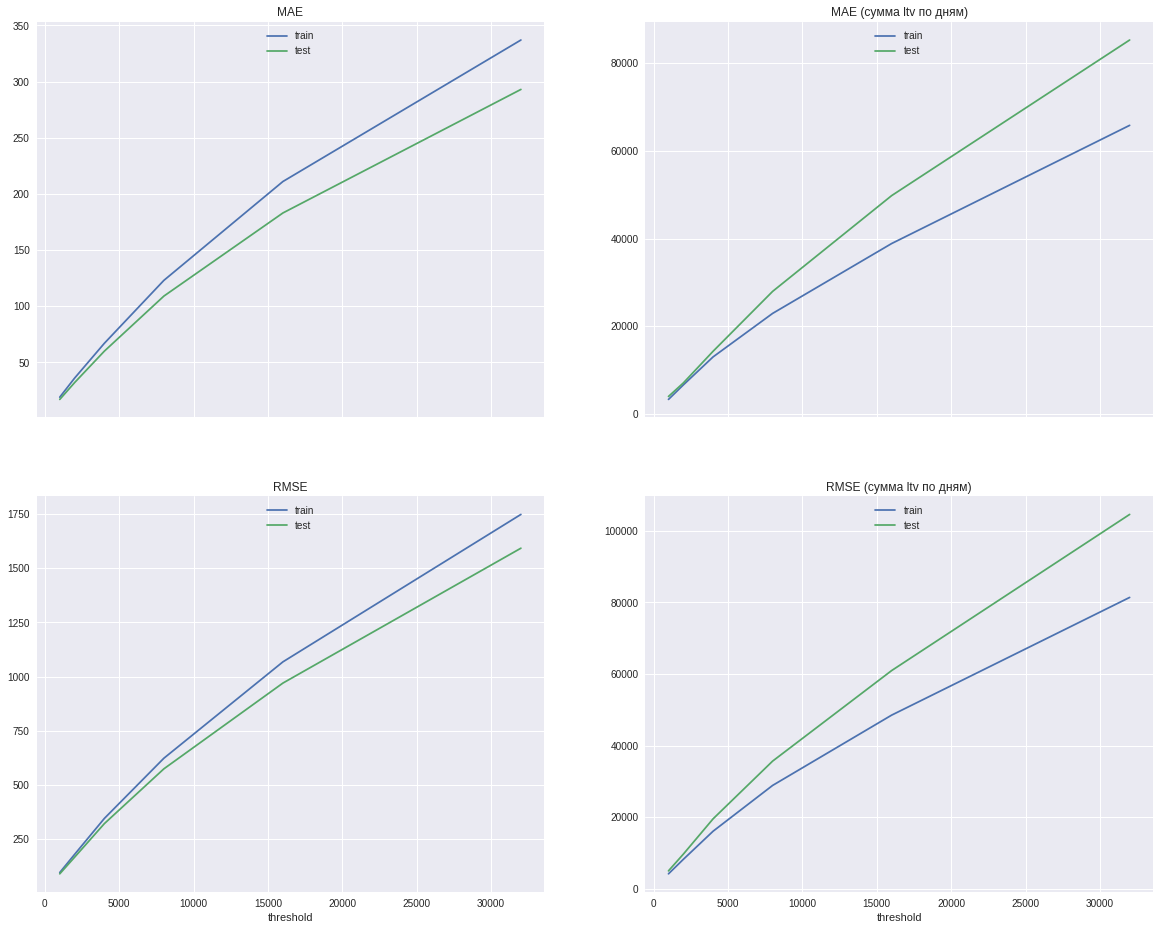

In [37]:
thresholds = np.array([1000 * (2 ** i) for i in range(6)])
mae_train = np.zeros_like(thresholds)
mae_test = np.zeros_like(thresholds)
rmse_train = np.zeros_like(thresholds)
rmse_test = np.zeros_like(thresholds)

mae_train_sum = np.zeros_like(thresholds)
mae_test_sum = np.zeros_like(thresholds)
rmse_train_sum = np.zeros_like(thresholds)
rmse_test_sum = np.zeros_like(thresholds)

ss = StandardScaler()
est = RandomForestRegressor(n_estimators=30, max_depth=8)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

for i in range(thresholds.size):
    # ограничение ltv cверху
    y0 = y.copy()
    y0_test = y_test.copy()
    t = thresholds[i]
    y0[y0 > t] = t
    y0_test[y0_test > t] = t
    
    std_est, y_pred, y_pred_test = train_model(X=X, y=y0, X_test=X_test, y_test=y0_test, model=std_est)
    
    Y = y0.to_frame().join(regday.to_frame())
    Y["pred"] = y_pred
    Y_test = y0_test.to_frame().join(regday_test.to_frame())
    Y_test["pred"] = y_pred_test
    
    mae_train[i] = mean_absolute_error(Y.revenue, Y.pred)
    mae_test[i] = mean_absolute_error(Y_test.revenue, Y_test.pred)
    rmse_train[i] = rmse(Y.revenue, Y.pred)
    rmse_test[i] = rmse(Y_test.revenue, Y_test.pred)
    
    Y = Y.groupby("regday").sum()
    Y_test = Y_test.groupby("regday").sum()
    
    mae_train_sum[i] = mean_absolute_error(Y.revenue, Y.pred)
    mae_test_sum[i] = mean_absolute_error(Y_test.revenue, Y_test.pred)
    rmse_train_sum[i] = rmse(Y.revenue, Y.pred)
    rmse_test_sum[i] = rmse(Y_test.revenue, Y_test.pred)

f, axes = plt.subplots(2, 2, figsize=(20, 16), sharex='col', sharey=False)
axes[0, 0].plot(thresholds, mae_train, label='train')
axes[0, 0].plot(thresholds, mae_test, label='test')
axes[0, 0].set_title("MAE")
axes[0, 0].legend(loc='upper center', shadow=True)
axes[1, 0].plot(thresholds, rmse_train, label='train')
axes[1, 0].plot(thresholds, rmse_test, label='test')
axes[1, 0].legend(loc='upper center', shadow=True)
axes[1, 0].set_title("RMSE")
axes[1, 0].set_xlabel("threshold")
axes[0, 1].plot(thresholds, mae_train_sum, label='train')
axes[0, 1].plot(thresholds, mae_test_sum, label='test')
axes[0, 1].set_title("MAE (сумма ltv по дням)")
axes[0, 1].legend(loc='upper center', shadow=True)
axes[1, 1].plot(thresholds, rmse_train_sum, label='train')
axes[1, 1].plot(thresholds, rmse_test_sum, label='test')
axes[1, 1].set_title("RMSE (сумма ltv по дням)")
axes[1, 1].legend(loc='upper center', shadow=True)
axes[1, 1].set_xlabel("threshold")
plt.show()

#### Зависимость ошибки от тестовой недели
модель - RandomForestRegressor(n_estimators=30, max_depth=8)

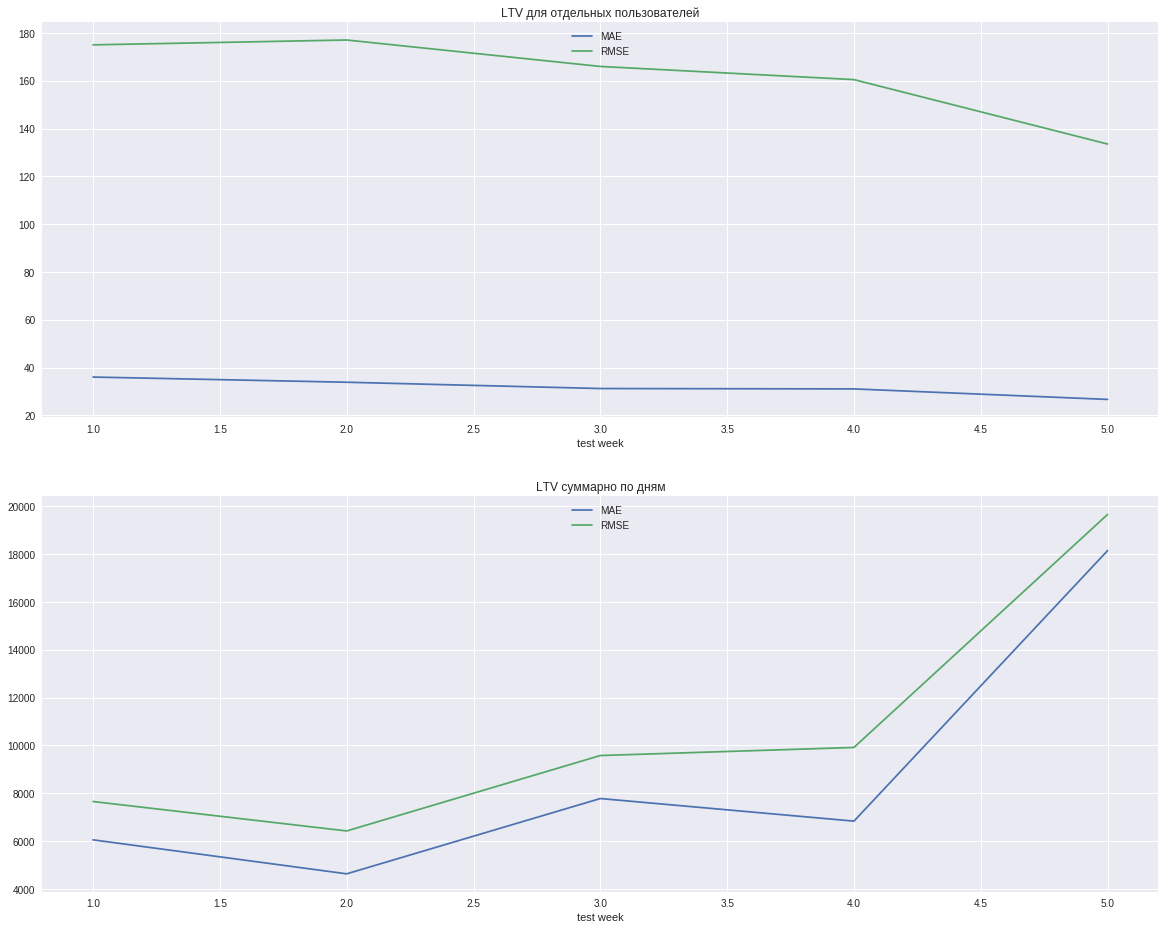

In [39]:
# ограничение ltv cверху
y0 = y.copy()
y0_test = y_test.copy()
t = 2000
y0[y0 > t] = t
y0_test[y0_test > t] = t

ss = StandardScaler()
est = RandomForestRegressor(n_estimators=30, max_depth=8)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

std_est, y_pred, y_pred_test = train_model(X=X, y=y0, X_test=X_test, y_test=y0_test, model=std_est)

Y = y0.to_frame().join(regday.to_frame())
Y["pred"] = y_pred
Y_test = y0_test.to_frame().join(regday_test.to_frame())
Y_test["pred"] = y_pred_test
Y_test["reg_week"] = (Y_test.regday - Y_test.regday.min()) // 7

n_test_weeks = int((Y_test.regday.max() - Y_test.regday.min()) // 7) + 1

week_mae = np.zeros(n_test_weeks)
week_rmse = np.zeros(n_test_weeks)
week_mae_sum = np.zeros(n_test_weeks)
week_rmse_sum = np.zeros(n_test_weeks)

for i in range(n_test_weeks):
    week_mae[i] = mean_absolute_error(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "revenue"], 
                                      Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "pred"])
    week_rmse[i] = rmse(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "revenue"], 
                        Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "pred"])
    
Y_test = Y_test.groupby("regday").sum().reset_index()
for i in range(n_test_weeks):
    week_mae_sum[i] = mean_absolute_error(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "revenue"], 
                                          Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "pred"])
    week_rmse_sum[i] = rmse(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "revenue"],
                            Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "pred"])
    
f, axes = plt.subplots(2, figsize=(20, 16))
axes[0].plot(np.arange(1, n_test_weeks + 1), week_mae, label="MAE")
axes[0].plot(np.arange(1, n_test_weeks + 1), week_rmse, label="RMSE")
axes[0].set_title("LTV для отдельных пользователей")
axes[0].set_xlabel("test week")
axes[0].legend(loc='upper center', shadow=True)
axes[1].plot(np.arange(1, n_test_weeks + 1), week_mae_sum, label="MAE")
axes[1].plot(np.arange(1, n_test_weeks + 1), week_rmse_sum, label="RMSE")
axes[1].set_title("LTV суммарно по дням")
axes[1].set_xlabel("test week")
axes[1].legend(loc='upper center', shadow=True)
plt.show()

#### Зависимость ошибки от ограничения LTV и тестовой недели 
модель - RandomForestRegressor(n_estimators=30, max_depth=8)

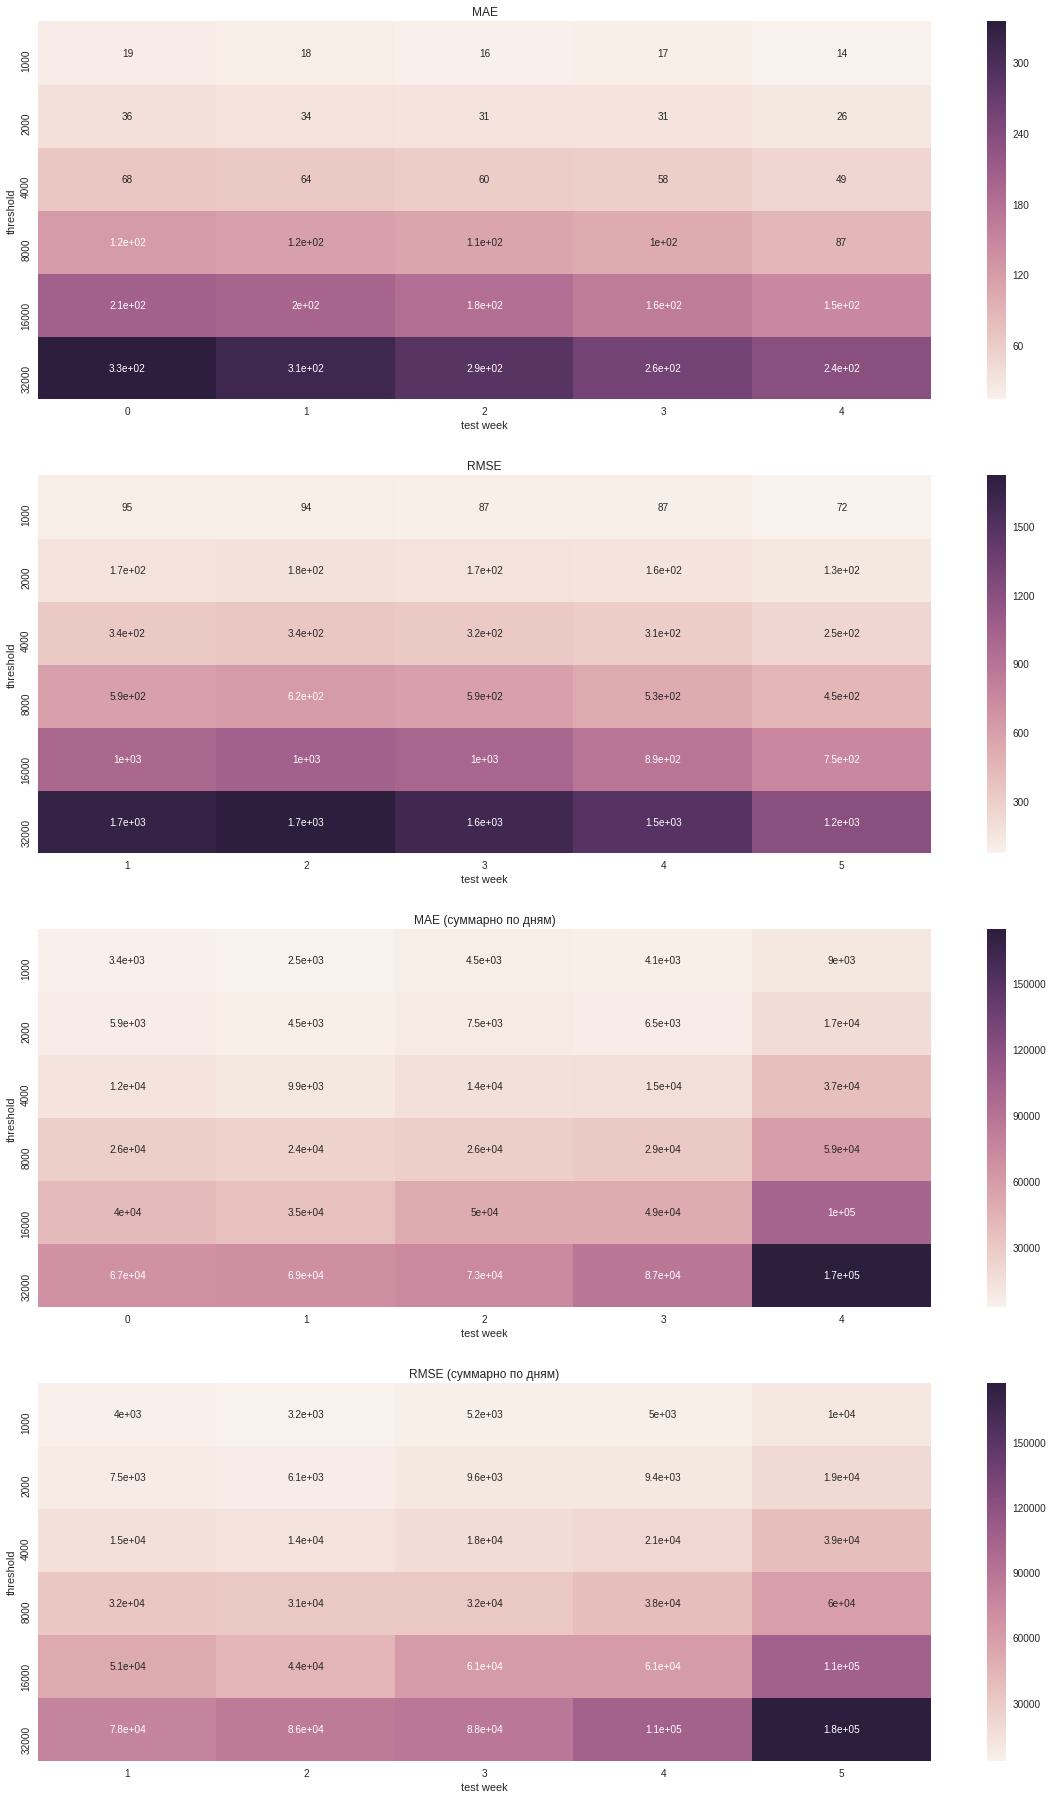

In [41]:
thresholds = np.array([1000 * (2 ** i) for i in range(6)])

n_test_weeks = int((regday_test.max() - regday_test.min()) // 7) + 1
n_test_weeks = 5

week_mae = np.zeros((thresholds.size, n_test_weeks))
week_rmse = np.zeros((thresholds.size, n_test_weeks))
week_mae_sum = np.zeros((thresholds.size, n_test_weeks))
week_rmse_sum = np.zeros((thresholds.size, n_test_weeks))

ss = StandardScaler()
est = RandomForestRegressor(n_estimators=30, max_depth=8)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

for i in range(thresholds.size):
    # ограничение ltv cверху
    y0 = y.copy()
    y0_test = y_test.copy()
    t = thresholds[i]
    y0[y0 > t] = t
    y0_test[y0_test > t] = t
    std_est, y_pred, y_pred_test = train_model(X=X, y=y0, X_test=X_test, y_test=y0_test, model=std_est)
    
    Y_test = y0_test.to_frame().join(regday_test.to_frame())
    Y_test["pred"] = y_pred_test
    
    for j in range(n_test_weeks):
        week_mae[i, j] = mean_absolute_error(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "revenue"], 
                                          Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "pred"])
        week_rmse[i, j] = rmse(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "revenue"], 
                            Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "pred"])
    
    Y_test = Y_test.groupby("regday").sum().reset_index()
    
    for j in range(n_test_weeks):
        week_mae_sum[i, j] = mean_absolute_error(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "revenue"], 
                                              Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "pred"])
        week_rmse_sum[i, j] = rmse(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "revenue"],
                                Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "pred"])

f, axes = plt.subplots(4, figsize=(20, 32))
sns.heatmap(week_mae, annot=True, ax=axes[0], yticklabels=thresholds)
axes[0].set_title("MAE")
axes[0].set_xlabel("test week")
axes[0].set_ylabel("threshold")
sns.heatmap(week_rmse, annot=True, ax=axes[1],  xticklabels=np.arange(1, 6), yticklabels=thresholds)
axes[1].set_title("RMSE")
axes[1].set_xlabel("test week")
axes[1].set_ylabel("threshold")
sns.heatmap(week_mae_sum, annot=True, ax=axes[2], yticklabels=thresholds)
axes[2].set_title("MAE (суммарно по дням)")
axes[2].set_xlabel("test week")
axes[2].set_ylabel("threshold")
sns.heatmap(week_rmse_sum, annot=True, ax=axes[3],  xticklabels=np.arange(1, 6), yticklabels=thresholds)
axes[3].set_title("RMSE (суммарно по дням)")
axes[3].set_xlabel("test week")
axes[3].set_ylabel("threshold")